# Single-Layer Graph Convolutional Networks (GCN) - Ablation Study

In this section, we explore on implementing a single GCN layer and we will specifically focus on three key components:

1. Self-connections (self-loops)
2. Non-linearities
3. Normalization

The aim is to understand the propagation rule for a GCN and its components and be able to implement it correctly.

The feature update rule for the next layer $ H_{k+1} $ in a graph convolutional network is given by the equation

$$
H_{k+1} = \sigma(\tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2} H_k \Omega_k)
$$

where  $\tilde{D}$ is the degree matrix with added self-loops, $\tilde{A}$ is the adjacency matrix with self-loops, $H_k$ are the features from the previous layer, $ \Omega_k $ is the weight matrix at layer $ k $, and $\sigma $ denotes the activation function.

## Setting a Seed for Reproducibility

To ensure that our results are reproducible, we will set a fixed seed for the random number generator. This step is crucial for educational and testing purposes, as it allows the same random numbers to be generated each time the notebook is run.



In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
np.random.seed(42)  # Setting a fixed seed for numpy random number generator
torch.manual_seed(42)

## Defining Helper Functions

Next, we define several helper functions:
- `relu`: The ReLU activation function.
- `initialize_graph`: Initializes a graph with one high-degree node and other nodes having random lower degrees.
- `add_self_connections`: Adds self-connections to the graph's adjacency matrix.
- `normalize_adjacency`: Normalizes the adjacency matrix.
- `plot_graph`: Plots the graph using NetworkX and Matplotlib.


In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def initialize_graph(num_nodes, high_degree):
    # Ensure the high_degree is less than the number of nodes
    if high_degree >= num_nodes:
        raise ValueError("high_degree must be less than the number of nodes")

    # Define the adjacency matrix A for the graph
    A = np.zeros((num_nodes, num_nodes))
    # Connect the first node to 'high_degree' other nodes
    A[0, 1:high_degree+1] = 1
    A[1:high_degree+1, 0] = 1

    # Assign random connections for the rest of the nodes, ensuring each has at least one connection
    for i in range(high_degree+1, num_nodes):
        # Randomly pick a node to connect with (not itself and not the first high-degree node)
        connections = np.random.choice(range(1, high_degree+1), np.random.randint(1, high_degree), replace=False)
        A[i, connections] = 1
        A[connections, i] = 1

    return A


def plot_graph(A):
    G = nx.Graph(A)
    layout = nx.spring_layout(G)
    nx.draw(G, layout, with_labels=True, node_color='lightblue', edge_color='gray', node_size=700, font_weight='bold')
    plt.show()


## Initialize Graph and Feature Matrix

Here we set up our graph parameters, initialize the feature matrix `H_k` for our nodes, and visualize the initial graph structure. This setup serves as the basis for our ablation study.


Initial feature matrix H_k:
 [[0.37454012 0.95071431 0.73199394]
 [0.59865848 0.15601864 0.15599452]
 [0.05808361 0.86617615 0.60111501]
 [0.70807258 0.02058449 0.96990985]
 [0.83244264 0.21233911 0.18182497]
 [0.18340451 0.30424224 0.52475643]]

Initial Graph structure:


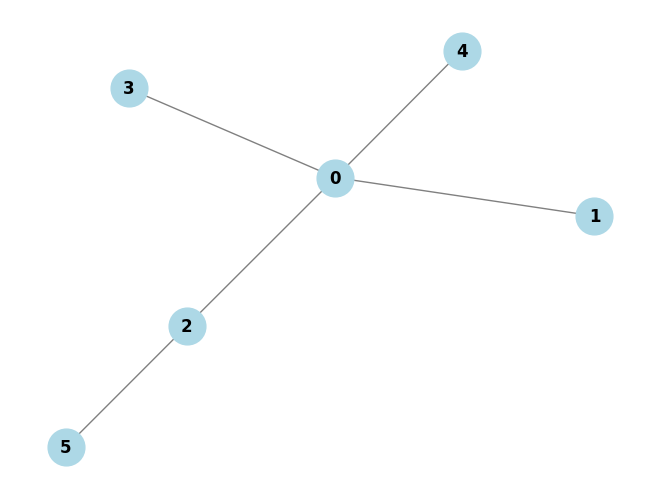

In [3]:
num_nodes = 6
high_degree = 4
H_k = np.random.rand(num_nodes, 3)
print("Initial feature matrix H_k:\n", H_k)
A = initialize_graph(num_nodes, high_degree)
print("\nInitial Graph structure:")
plot_graph(A)


## Initializing the Weight Matrix (Omega_k)

Before applying the GCN update rule, we need to define the weight matrix `Omega_k`. This matrix is a key component of the GCN, as it transforms the feature vectors during the update step. We will initialize it with random values.


In [4]:
# Define the dimensions of the weight matrix
input_features = H_k.shape[1]  # Number of input features (columns of H_k)
output_features = 2  # Number of output features (can be chosen based on your model's design)

# Initialize the weight matrix Omega_k with random values
Omega_k = np.random.rand(input_features, output_features)
print("Weight matrix Omega_k:")
print(Omega_k)


Weight matrix Omega_k:
[[0.01326496 0.94220176]
 [0.56328822 0.3854165 ]
 [0.01596625 0.23089383]]


## Add Self-Connections and Normalize Adjacency Matrix

To implement the propagation rule, we first need to define two functions: one for adding self-connections to the adjacency matrix and another for normalizing the adjacency matrix.


### Adding Self-Connections

Self-connections are added to the adjacency matrix to include each node's own features when aggregating neighbor features. This is mathematically represented as:

$$
\tilde{A} = A + I
$$

where $A$ is the original adjacency matrix, and $I$ is the identity matrix of size equal to the number of nodes in the graph.

### Normalizing the Adjacency Matrix

Normalization of the adjacency matrix is an essential step to ensure that the scale of the feature vectors remains constant over the graph. The normalized adjacency matrix is computed as:

$$
\hat{A} = \tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2}
$$

where $\tilde{A}$ is the adjacency matrix with self-connections and $\tilde{D}$ is the diagonal degree matrix of $\tilde{A}$, with each diagonal element $\tilde{D}_{ii}$ being the sum of the weights of the edges connected to node $i$, including the self-connection.

These steps are crucial for the propagation rule in GCNs and directly influence the performance of the graph convolution operation.



In [5]:
def add_self_connections(A):
    """
    Add self-connections to the adjacency matrix.

    This function adds an identity matrix to the adjacency matrix `A`, which
    effectively adds a self-loop to each node in the graph. This is a common
    preprocessing step in graph neural network implementations.

    Parameters:
    A (np.ndarray): The adjacency matrix to modify.

    Returns:
    np.ndarray: The adjacency matrix with self-connections added.
    """
    I = np.eye(A.shape[0])
    return A + I


def normalize_adjacency(A_hat):
    """
    Normalize the adjacency matrix.

    This function applies symmetric normalization to the adjacency matrix
    `A_hat`. The normalization is done using the inverse square root of the
    degree matrix. This step is important for many graph-based learning
    algorithms to ensure that the scale of the feature representations is not
    skewed by node degree.

    Parameters:
    A_hat (np.ndarray): The adjacency matrix with self-connections.

    Returns:
    np.ndarray: The normalized adjacency matrix.
    """
    D_hat_inv_sqrt = np.diag(1.0 / np.sqrt(np.sum(A_hat, axis=0)))
    return D_hat_inv_sqrt.dot(A_hat).dot(D_hat_inv_sqrt)


## GCN Update: With and Without Self-Connections

Now, let's observe the impact of self-connections in GCN. We will compare the embeddings obtained from the GCN update rule with and without self-connections.


In [6]:
# GCN update steps
A_hat = add_self_connections(A)
H_k_no_self = sigmoid(normalize_adjacency(A).dot(H_k).dot(Omega_k))
H_k_self = sigmoid(normalize_adjacency(A_hat).dot(H_k).dot(Omega_k))
print("Without self-connections:\n", H_k_no_self)
print("\nWith self-connections:\n", H_k_self)

Without self-connections:
 [[0.57696772 0.80536064]
 [0.56858758 0.60925057]
 [0.58031133 0.64676562]
 [0.56858758 0.60925057]
 [0.56858758 0.60925057]
 [0.58718334 0.59215929]]

With self-connections:
 [[0.58028601 0.74915003]
 [0.55571092 0.64817279]
 [0.59460658 0.63946293]
 [0.54806409 0.67489895]
 [0.56005664 0.67589901]
 [0.57310076 0.60370023]]


### Analysis: Impact of Self-Connections

The results above show distinct differences in the feature matrices with and without self-connections. With self-connections, each node incorporates its own features along with its neighbors', leading to a more integrated feature representation. This often results in a richer and more nuanced feature update. Without self-connections, nodes solely rely on their neighbors, which might be limiting in graphs where individual node features are significant.


## GCN Update: With and Without Non-linearities

In this section, we analyze the role of the ReLU non-linearity in GCN. We will perform the GCN update once without applying ReLU and then with it, to contrast the differences.


In [7]:
# GCN update without non-linearities
H_k_no_nonlin = normalize_adjacency(A_hat).dot(H_k).dot(Omega_k)
print("Without non-linearities:")
print(H_k_no_nonlin)

# GCN update with non-linearities (sigmoid function)
H_k_with_nonlin = sigmoid(normalize_adjacency(A_hat).dot(H_k).dot(Omega_k))
print("\nWith non-linearities (Sigmoid):")
print(H_k_with_nonlin)

Without non-linearities:
[[0.32394759 1.09408423]
 [0.22377281 0.61101712]
 [0.38304196 0.57303385]
 [0.19285185 0.73042693]
 [0.24139191 0.73498851]
 [0.29451351 0.42090686]]

With non-linearities (Sigmoid):
[[0.58028601 0.74915003]
 [0.55571092 0.64817279]
 [0.59460658 0.63946293]
 [0.54806409 0.67489895]
 [0.56005664 0.67589901]
 [0.57310076 0.60370023]]


### Analysis: Role of Non-linearities

The inclusion of the sigmoid non-linearity introduces an element of non-linear transformation to the features. This can be observed in the contrast between the `H_k_no_nonlin` and `H_k_with_nonlin` matrices. Non-linearities allow the network to capture more complex patterns, which is particularly important in learning intricate graph structures. The absence of ReLU results in a purely linear transformation, potentially reducing the model's expressive power.


## GCN Update: With and Without Normalization

Finally, let's explore how normalization affects the GCN update process. We'll compare the embeddings updates when normalization is applied and when it's omitted.



In [8]:

# GCN update without normalization
H_k_no_norm = (A_hat.dot(H_k).dot(Omega_k))
print("Without normalization:")
print(H_k_no_norm)

# GCN update with normalization
H_k_with_norm = (normalize_adjacency(A_hat).dot(H_k).dot(Omega_k))
print("\nWith normalization:")
print(H_k_with_norm)

Without normalization:
[[1.31879865 3.88306964]
 [0.65049692 1.54853363]
 [1.23264379 1.82691208]
 [0.58865501 1.78735325]
 [0.68573513 1.7964764 ]
 [0.68046217 0.93858586]]

With normalization:
[[0.32394759 1.09408423]
 [0.22377281 0.61101712]
 [0.38304196 0.57303385]
 [0.19285185 0.73042693]
 [0.24139191 0.73498851]
 [0.29451351 0.42090686]]


### Analysis: Importance of Normalization

Normalization plays a critical role in balancing the influence of nodes based on their degree. In `H_k_with_norm`, the feature updates are scaled, preventing high-degree nodes from dominating the feature space. Conversely, in `H_k_no_norm`, the lack of normalization can lead to skewed updates, especially in nodes with higher connectivity. This can be critical in maintaining the stability and effectiveness of the learning process in GCNs.


Now, we will extend our understanding of GCNs by building and training a 2-layer GCN classifier. This model will be used for node classification. We'll visualize various aspects of the training process, including:
The distribution of embeddings at each layer during training.
The distribution of learned transformation weights (Omega_k).
The training loss progression.
Evaluation measures (accuracy, sensitivity, specificity) on test sets.
Let's start by defining our 2-layer GCN model and preparing the training setup.

# Two-Layer GCN Classifier ( Task: Graph Classification )

In [9]:
import networkx as nx
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Set seeds for reproducibility
random_seed = 42
random.seed(random_seed)        # Python's built-in random module
np.random.seed(random_seed)     # NumPy's random number generator
torch.manual_seed(random_seed)  # PyTorch's random number generator

# If using a GPU, also set the seed for CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Creating and Classifying Random Molecular Graphs

This script generates random molecular graphs and classifies them based on their atomic composition. Key functions include:

- `create_random_molecule_graph`: Generates a random molecular graph with specified atoms and bonds.
- `classify_molecule`: Determines the type of molecule based on certain criteria.
- `generate_balanced_molecule_dataset`: Produces a balanced dataset of random molecule graphs for each type.

Use this to create datasets for machine learning tasks involving molecular structures.


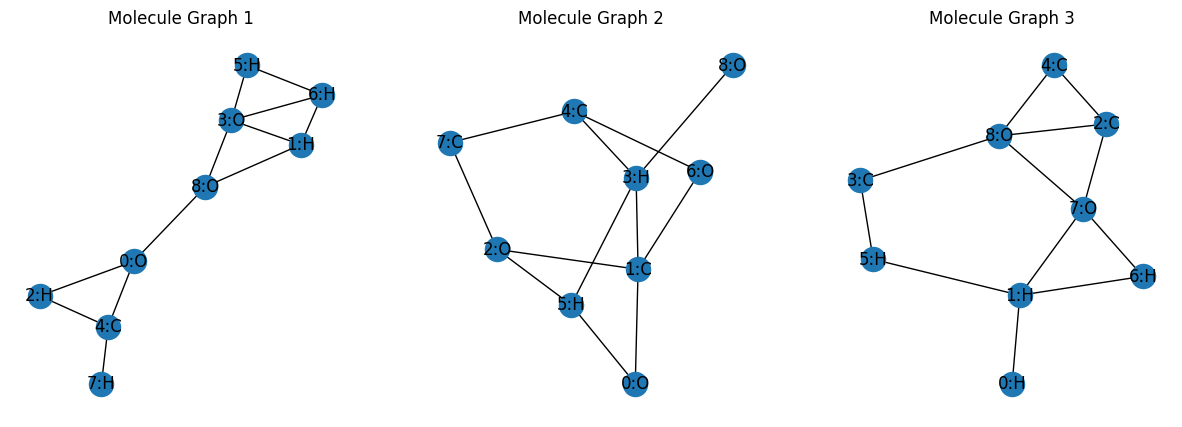

In [10]:
import networkx as nx
import random
import torch

def create_random_molecule_graph(num_atoms=9, num_bonds=12):
    """
    Creates a random molecular graph with a specified number of atoms and bonds.

    Args:
        num_atoms (int): The number of atoms in the molecule.
        num_bonds (int): The number of bonds between atoms in the molecule.

    Returns:
        (nx.Graph, list): A tuple containing the generated molecular graph and the list of atom labels.
    """
    G = nx.Graph()
    atom_labels = [f"{i}:{random.choice(['H', 'C', 'O'])}" for i in range(num_atoms)]
    G.add_nodes_from(atom_labels)

    for _ in range(num_bonds):
        atom1, atom2 = random.choice(atom_labels), random.choice(atom_labels)
        while atom1 == atom2 or G.has_edge(atom1, atom2):
            atom1, atom2 = random.choice(atom_labels), random.choice(atom_labels)
        G.add_edge(atom1, atom2)

    return G, atom_labels

def classify_molecule1(G):
    """
    Classifies a molecule based on its atomic composition.

    Args:
        G (nx.Graph): The molecular graph.

    Returns:
        int: The type of molecule (1, 2, or 0).
    """
    atom_labels = list(G.nodes)
    num_carbon = sum(1 for label in atom_labels if label.endswith(":C"))
    num_oxygen = sum(1 for label in atom_labels if label.endswith(":O"))

    return 1 if num_carbon > num_oxygen else 2 if num_oxygen > num_carbon else 0

def classify_molecule(G):
    """
    Classifies a molecule into type 1 or type 2 based on complex criteria (without considering nitrogen).

    Args:
        G (nx.Graph): The molecular graph.

    Returns:
        int: The type of molecule (1 or 2).
    """
    atom_labels = list(G.nodes)
    num_carbon = sum(1 for label in atom_labels if label.endswith(":C"))
    num_oxygen = sum(1 for label in atom_labels if label.endswith(":O"))
    num_hydrogen = sum(1 for label in atom_labels if label.endswith(":H"))
    num_bonds = len(G.edges)

    # Define complex criteria for classification
    if num_oxygen >= 2 and num_hydrogen >= 3 and num_carbon >= 1 and num_bonds >= 3:
        return 1
    elif num_oxygen >= 1 and num_carbon >= 2 and num_bonds >= 2:
        return 2
    else:
        return 0


def generate_balanced_molecule_dataset(num_samples_per_type):
    """
    Generates a balanced dataset of random molecule graphs.

    Args:
        num_samples_per_type (int): The number of samples per molecule type.

    Returns:
        list: A list of tuples, each containing a graph, its atom labels, and its classification.
    """
    dataset = []
    while len(dataset) < num_samples_per_type * 2:
        G, atom_labels = create_random_molecule_graph()
        classification = classify_molecule(G)
        if classification in [1, 2]:
            dataset.append((G, atom_labels, classification))
    return dataset

def graph_to_tensors(G, atom_labels):
    """
    Converts a networkx graph of a molecule into tensor representations.

    Args:
        G (nx.Graph): The molecular graph.
        atom_labels (list): List of atom labels in the molecule.

    Returns:
        tuple: A tuple containing the tensor representation of atom types (X) and adjacency matrix (A).
    """
    atom_types = {'H': [1, 0, 0], 'C': [0, 1, 0], 'O': [0, 0, 1]}
    X = torch.tensor([atom_types[node.split(':')[1]] for node in atom_labels], dtype=torch.float)

    N = len(atom_labels)
    A = torch.zeros((N, N), dtype=torch.float)
    for i, j in G.edges:
        idx1 = atom_labels.index(i)
        idx2 = atom_labels.index(j)
        A[idx1, idx2] = 1
        A[idx2, idx1] = 1

    return X, A


# Generating a few random molecule graphs for visualization
graphs = [create_random_molecule_graph() for _ in range(3)]

# Plotting the generated graphs
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (G, atom_labels) in enumerate(graphs):
    pos = nx.spring_layout(G)  # Using spring layout for visual aesthetics
    nx.draw(G, pos, with_labels=True, ax=axes[i])
    axes[i].set_title(f"Molecule Graph {i+1}")

plt.show()



## Implementing a Graph Convolutional Network (GCN)

This code constructs a simple Graph Neural Network model using GCN layers for processing graph-structured data. Key components include:

- `GCNLayer`: A layer in the GCN, applying linear transformation and optional non-linearity to node features.
- `GraphNeuralNetwork`: A neural network model comprising two GCN layers.



In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)

class GCNLayer(nn.Module):
    """
    A single layer of a Graph Convolutional Network (GCN).
    ...
    """
    def __init__(self, input_dim, output_dim, use_nonlinearity=True):
        super(GCNLayer, self).__init__()
        self.use_nonlinearity = use_nonlinearity
        self.Omega = nn.Parameter(torch.randn(input_dim, output_dim) * torch.sqrt(torch.tensor(2.0) / (input_dim + output_dim)))
        self.beta = nn.Parameter(torch.zeros(output_dim))

    def forward(self, H_k, A_normalized):
        agg = torch.matmul(A_normalized, H_k)
        H_k_next = torch.matmul(agg, self.Omega) + self.beta
        return F.relu(H_k_next) if self.use_nonlinearity else H_k_next

class GraphNeuralNetwork(nn.Module):
    """
    A simple Graph Neural Network model using two layers of Graph Convolutional Network (GCN)
    for binary classification. The sigmoid activation is applied in the output layer only if
    use_nonlinearity is set to True.
    """
    def __init__(self, input_dim, hidden_dim, use_nonlinearity=True, use_self_connections=True, use_normalization=True):
        super(GraphNeuralNetwork, self).__init__()
        self.use_nonlinearity = use_nonlinearity
        self.use_self_connections = use_self_connections
        self.use_normalization = use_normalization

        # Define GCN layers
        self.gcn1 = GCNLayer(input_dim, hidden_dim, self.use_nonlinearity)
        self.gcn2 = GCNLayer(hidden_dim, 1, False)

    def forward(self, A, X, return_embeddings=False):

        # Apply self-connections if enabled
        if self.use_self_connections:
            A = A + torch.eye(A.size(0))

        # Apply normalization if enabled
        if self.use_normalization:
            epsilon = 1e-5  # Small constant to avoid division by zero
            d = A.sum(1) + epsilon
            D_inv = torch.diag(torch.pow(d, -0.5))
            A = D_inv @ A @ D_inv

        # Pass through GCN layers
        H1 = self.gcn1(X, A)
        H2 = self.gcn2(H1, A)

        output = torch.sigmoid(H2.mean(dim=0))
        # Check for NaN values and handle them
        if torch.isnan(output).any():
            output = torch.where(torch.isnan(output), torch.zeros_like(output), output)

        if return_embeddings:
            return output, H1, H2
        else:
            return output

## Visualization Tools for Model Training and Analysis

This section provides functions to visualize training loss, node embeddings, and weight distributions in a GCN model:

- `plot_training_loss`: Plots the loss over training epochs.
- `visualize_embeddings`: Uses PCA to reduce node embeddings to 2D for visualization.
- `visualize_omega_distribution`: Creates heatmaps of the weight distributions in GCN layers.

These tools help in understanding and analyzing the training process and the model's internal representations.


In [12]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns

def plot_training_loss(loss_values):
    """
    Plots the training loss over epochs.

    Args:
        loss_values (list): A list of loss values, one for each epoch of training.

    This function creates a line plot where the X-axis represents the epoch number
    and the Y-axis represents the loss value for each epoch.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(loss_values) + 1), loss_values, label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()



def visualize_embeddings(embeddings_list, labels_list, title, epochs):
    """
    Visualize embeddings using PCA, with different colors for each label.
    Each epoch is visualized in a separate subplot, arranged horizontally.

    :param embeddings_list: List of embeddings from different epochs.
    :param labels_list: List of labels corresponding to each point in the embeddings.
    :param title: Title for the plot.
    :param epochs: List of epochs corresponding to the embeddings.
    """
    num_epochs = len(embeddings_list)
    pca = PCA(n_components=2)  # PCA for dimensionality reduction to 2 dimensions
    fig, axes = plt.subplots(1, num_epochs, figsize=(5 * num_epochs, 5))  # Adjust subplot size as needed

    for i, embeddings in enumerate(embeddings_list):
        if embeddings.shape[1] < 2:
            print(f"Skipping PCA for Epoch {epochs[i]} - insufficient dimensions")
            continue

        embeddings_2d = pca.fit_transform(embeddings)
        unique_labels = np.unique(labels_list[i])

        for label in unique_labels:
            # Select embeddings for the current label
            indices = [j for j, x in enumerate(labels_list[i]) if x == label]
            selected_embeddings = embeddings_2d[indices, :]

            # Plot
            axes[i].scatter(selected_embeddings[:, 0], selected_embeddings[:, 1], label=f'Label {label}', alpha=0.5)

        axes[i].set_title(f'Epoch {epochs[i]}')
        axes[i].set_xlabel('PCA Component 1')
        axes[i].set_ylabel('PCA Component 2')
        axes[i].legend()

    plt.suptitle(title)
    plt.show()


def visualize_omega_distribution(layers, epochs):
    """
    Visualizes the distribution of weights (Omega) in each GCN layer of the Graph Neural Network across different epochs using smooth KDE plots.

    Args:
        layers (list): A list containing tuples of (layer_name, weight_arrays), where weight_arrays is a list of numpy arrays of the weights at each epoch.
        epochs (list): A list of epoch numbers corresponding to the weight arrays.
    """
    for layer_name, weight_arrays in layers:
        plt.figure(figsize=(12, 6))
        for i, weights in enumerate(weight_arrays):
            omega_values = weights.flatten()  # Flatten the array for KDE plot
            sns.kdeplot(omega_values, fill=True, label=f'Epoch {epochs[i]}')  # Updated from 'shade' to 'fill'

        plt.title(f'{layer_name} Weight Distribution Across Epochs', fontsize=16)
        plt.xlabel('Weight Values', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.legend()
        plt.show()



## Training and Testing Functions for GCN Models

Defines functions to train and test Graph Neural Network models:

- `train_epoch`: Conducts one training epoch, returning the average loss.
- `test`: Evaluates the model on a test dataset, returning accuracy and other metrics.

Use these functions for iterative model training and evaluation on test data.


In [13]:
import torch

# Training function

def train_epoch(model, dataset, optimizer, criterion, return_embeddings=False):
    total_loss = 0
    all_embeddings_H1 = []
    all_labels_H1 = []

    for X, A, label in dataset:
        optimizer.zero_grad()

        # Forward pass with optional embeddings
        if return_embeddings:
            output, H1, _ = model(A, X, return_embeddings=True)
            all_embeddings_H1.append(H1.detach().cpu().numpy())  # Store H1 embeddings
        else:
            output = model(A, X)

        # Prepare label for BCELoss
        adjusted_label = 1 if label == 1 else 0
        label_tensor = torch.tensor([float(adjusted_label)], dtype=torch.float)
        all_labels_H1.append(label_tensor.detach().cpu().numpy())

        # Flatten the output to match the label tensor shape
        output_flat = output.view(-1)

        # Compute loss
        loss = criterion(output_flat, label_tensor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataset)

    if return_embeddings:
        return average_loss, (all_embeddings_H1,all_labels_H1)
    else:
        return average_loss


# Testing function
def test(model, dataset):
    model.eval()
    true_labels = []
    predicted_labels = []
    correct = 0

    with torch.no_grad():
        for X, A, label in dataset:
            output = model(A, X)

            # Convert sigmoid output to binary prediction
            predicted = (output >= 0.5).int().item()

            # Adjust labels to match binary predictions (0 and 1)
            adjusted_label = 1 if label == 1 else 0

            true_labels.append(adjusted_label)
            predicted_labels.append(predicted)
            correct += (predicted == adjusted_label)

    accuracy = correct / len(dataset)
    return true_labels, predicted_labels, accuracy


## Setting Up and Executing the Training Process

Outlines the process for preparing a dataset, setting up the GCN model, and conducting training:

- Steps include data preparation, model initialization, and configuration.
- Setting up the loss function and optimizer.
- Running the training loop and visualizing training progress.

Follow these steps to train the GCN model on a specific dataset and visualize the training outcomes.


In [14]:
import random
import torch.nn as nn
import torch.optim as optim


# Generate a balanced dataset of random molecule graphs
num_samples_per_type = 200
balanced_molecule_dataset = generate_balanced_molecule_dataset(num_samples_per_type)

# Convert the dataset to tensor format for neural network processing
balanced_molecule_dataset_tensors = [graph_to_tensors(G, atom_labels) + (label,) for G, atom_labels, label in balanced_molecule_dataset]

# Split the dataset into training and test sets
random.shuffle(balanced_molecule_dataset_tensors)
train_set_size = int(len(balanced_molecule_dataset_tensors) * 0.8)
train_dataset = balanced_molecule_dataset_tensors[:train_set_size]
test_dataset = balanced_molecule_dataset_tensors[train_set_size:]

GraphNeuralNetwork(
  (gcn1): GCNLayer()
  (gcn2): GCNLayer()
)
Model Configuration:
Input Dimension: 3
Hidden Dimension: 64
Output Dimension: 1
Use Nonlinearity: True
Use Self-Connections: True
Use Normalization: True
Epoch 1, Loss: 0.6593268999829889
Epoch 2, Loss: 0.5846898308955133
Epoch 3, Loss: 0.5138466766569764
Epoch 4, Loss: 0.45878638778813186
Epoch 5, Loss: 0.4218769191997126
Epoch 6, Loss: 0.3981533665442839
Epoch 7, Loss: 0.38269446755875836
Epoch 8, Loss: 0.3723222371438169
Epoch 9, Loss: 0.3651574053816148
Epoch 10, Loss: 0.36006896977123687
Epoch 11, Loss: 0.35635560014052314
Epoch 12, Loss: 0.35357202370796587
Epoch 13, Loss: 0.35141128129907884
Epoch 14, Loss: 0.34967472060743604
Epoch 15, Loss: 0.3482381301391797
Epoch 16, Loss: 0.3470167677356585
Epoch 17, Loss: 0.3459160765116394
Epoch 18, Loss: 0.34495443968789913
Epoch 19, Loss: 0.3441249857325602
Epoch 20, Loss: 0.34338417288345224
Epoch 21, Loss: 0.3427167087626003
Epoch 22, Loss: 0.3420855755492994
Epoch 23, L

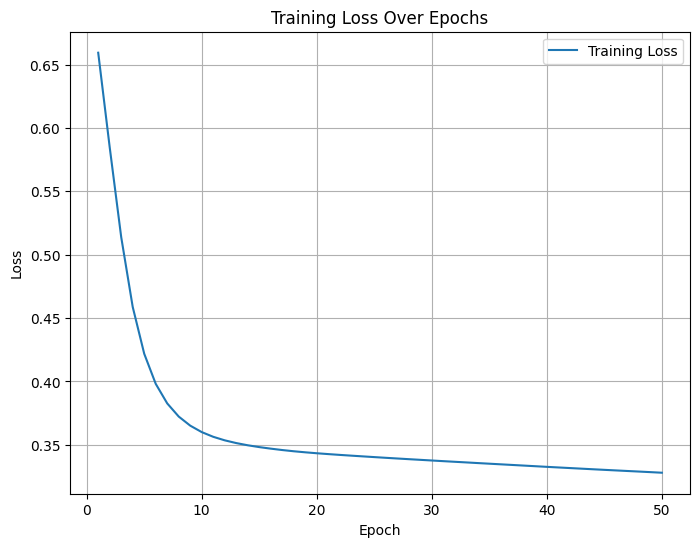

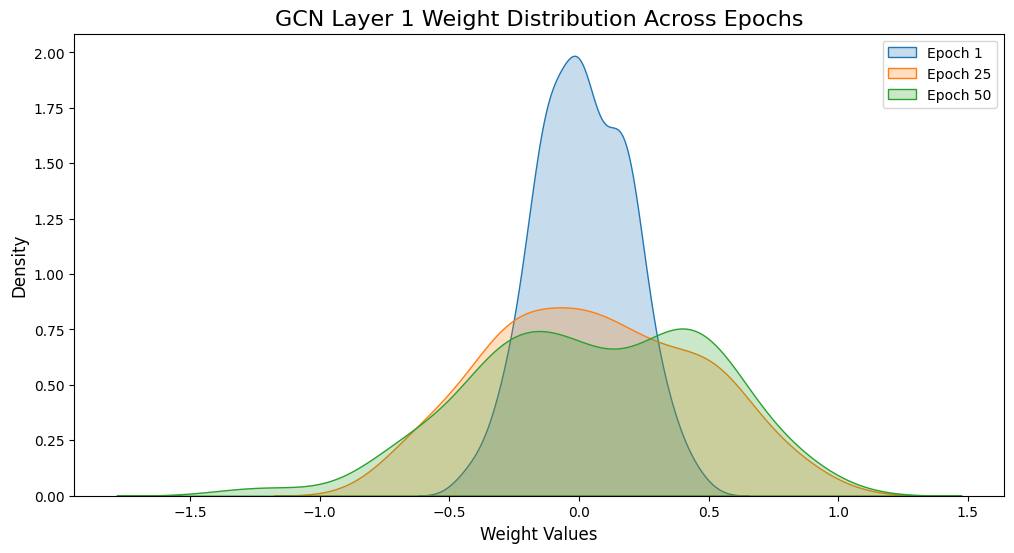

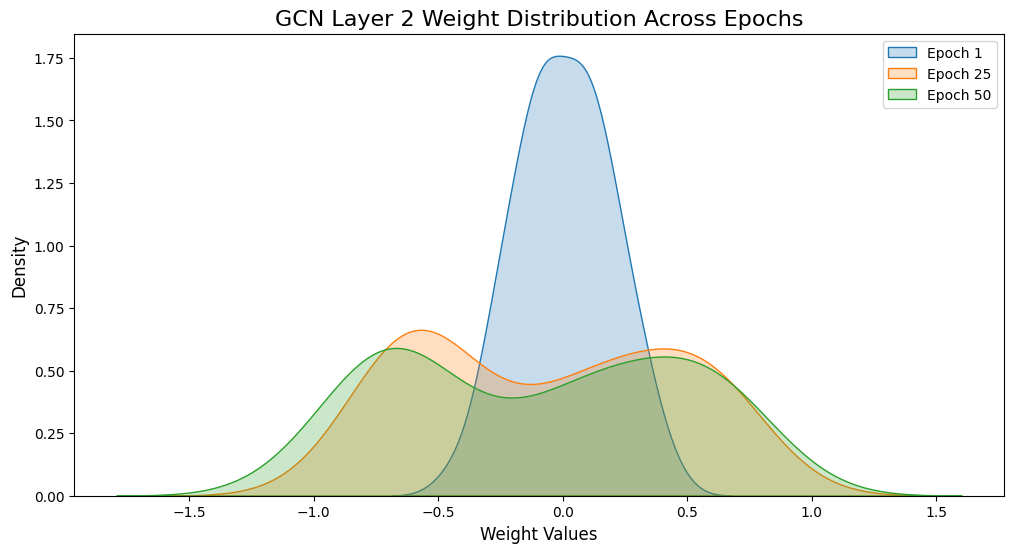

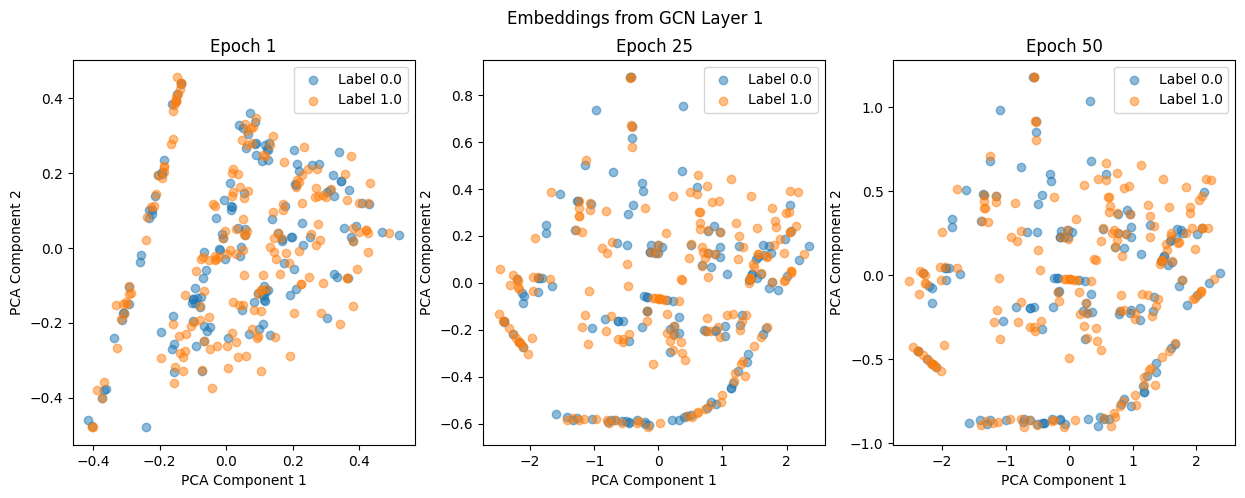

True labels: [0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Predicted labels: [0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0]
Accuracy: 0.8375
Precision: 0.8365
Sensitivity: 0.8396
F1-score: 0.8369


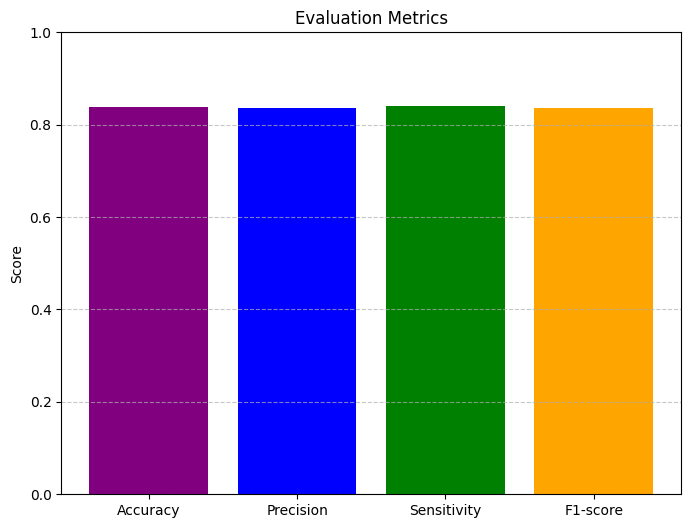

In [15]:

num_epochs = 50

# Define the Graph Neural Network model, loss function, and optimizer
model = GraphNeuralNetwork(
    input_dim=3,
    hidden_dim=64,
    use_nonlinearity=True,  # Set to False to remove nonlinearities
    use_self_connections=True,  # Set to False to remove self-connections
    use_normalization=True  # Set to False to remove normalization
)

print(model)

# Print out the model's configuration for verification
print("Model Configuration:")
print(f"Input Dimension: {model.gcn1.Omega.shape[0]}")
print(f"Hidden Dimension: {model.gcn1.Omega.shape[1]}")
print(f"Output Dimension: {model.gcn2.Omega.shape[1]}")
print(f"Use Nonlinearity: {model.use_nonlinearity}")
print(f"Use Self-Connections: {model.use_self_connections}")
print(f"Use Normalization: {model.use_normalization}")

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize a list to store loss values for visualization
loss_values = []

# Initialize lists to store weights for each layer at specific epochs
gcn1_weights = []
gcn2_weights = []
embeddings_layer_1 = []
labels_layer_1 = []

selected_epochs = [1, num_epochs//2, num_epochs]  # The epochs you want to visualize

# Training loop
for epoch in range(num_epochs):
    if epoch + 1 in selected_epochs:
        # Train and return embeddings for selected epochs
        loss, (epoch_embeddings_1, epoch_labels_1) = train_epoch(model, train_dataset, optimizer, criterion, return_embeddings=True)

        # Aggregating embeddings from all batches
        embeddings_layer_1.append(np.concatenate(epoch_embeddings_1, axis=0))
        labels_layer_1.append(np.concatenate(epoch_labels_1, axis=0))

    else:
        # Train without returning embeddings for other epochs
        loss = train_epoch(model, train_dataset, optimizer, criterion)

    print(f"Epoch {epoch+1}, Loss: {loss}")
    loss_values.append(loss)

    # Store the weights of each layer at selected epochs
    if epoch + 1 in selected_epochs:
        gcn1_weights.append(model.gcn1.Omega.detach().numpy().copy())
        gcn2_weights.append(model.gcn2.Omega.detach().numpy().copy())

# Plot the training loss after the completion of training
plot_training_loss(loss_values)

# Visualize the distribution of weights for each layer at selected epochs
visualize_omega_distribution([("GCN Layer 1", gcn1_weights), ("GCN Layer 2", gcn2_weights)], epochs=selected_epochs)

visualize_embeddings(embeddings_layer_1, labels_layer_1, title="Embeddings from GCN Layer 1", epochs=selected_epochs)


from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Evaluate the model on the test set
true_labels, predicted_labels, accuracy = test(model, test_dataset)

# Debug: Print true and predicted labels
print("True labels:", true_labels)
print("Predicted labels:", predicted_labels)

# Calculate precision, sensitivity (recall), and F1-score
precision = precision_score(true_labels, predicted_labels, average='macro')
sensitivity = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Print out the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"F1-score: {f1:.4f}")

# Visualize the performance metrics
# These metrics provide a comprehensive view of the model's performance.

# Prepare data for visualization
evaluation_metrics = [accuracy, precision, sensitivity, f1]
metric_names = ['Accuracy', 'Precision', 'Sensitivity', 'F1-score']

# Create a bar plot for the evaluation metrics
plt.figure(figsize=(8, 6))
plt.bar(metric_names, evaluation_metrics, color=['purple', 'blue', 'green', 'orange'])
plt.title('Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1.0)  # Set y-axis limit to maintain consistency in scale
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines for readability
plt.show()


Epoch 1, Loss: 0.6533001393079758
Epoch 2, Loss: 0.575489491270855
Epoch 3, Loss: 0.5052059686277062
Epoch 4, Loss: 0.45216298958985135
Epoch 5, Loss: 0.4175837671966292
Epoch 6, Loss: 0.39538378998695406
Epoch 7, Loss: 0.38084291178383867
Epoch 8, Loss: 0.3710616115015
Epoch 9, Loss: 0.3642861167551018
Epoch 10, Loss: 0.3594571710505988

Performance Metrics for Configuration: NL=True, SC=True, NM=True
Accuracy: 0.8375
Precision: 0.8365
Sensitivity: 0.8396
F1-score: 0.8369
--------------------------------------------------
Epoch 1, Loss: 0.6207058374769986
Epoch 2, Loss: 0.5064576220000163
Epoch 3, Loss: 0.43418913187924774
Epoch 4, Loss: 0.397353111821576
Epoch 5, Loss: 0.3794650494884991
Epoch 6, Loss: 0.3704313539012219
Epoch 7, Loss: 0.3656306604836573
Epoch 8, Loss: 0.3629557877768093
Epoch 9, Loss: 0.361400159099685
Epoch 10, Loss: 0.3604589803837371

Performance Metrics for Configuration: NL=False, SC=True, NM=True
Accuracy: 0.8125
Precision: 0.8139
Sensitivity: 0.8169
F1-score:

<ipython-input-16-191bd8f10fa1>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(


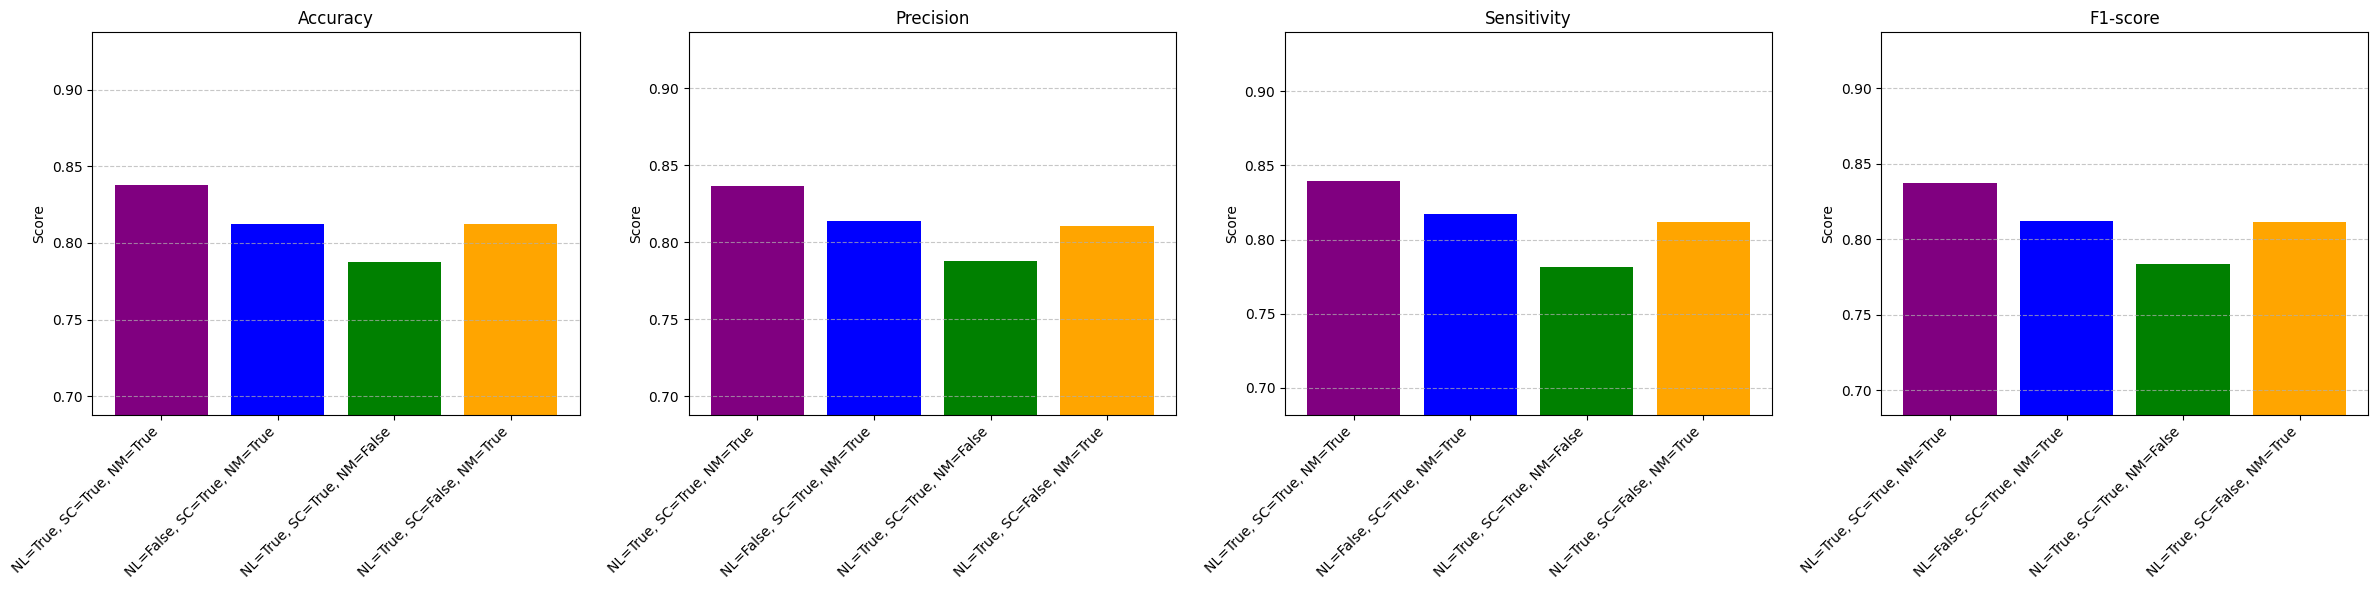

In [16]:

configurations = [
    (True, True, True),
    (False, True, True),
    (True, True, False),
    (True, False, True)

]

config_results = []

# Loop over the configurations
for nonlinearity, self_connections, normalization in configurations:
    # Initialize model with current configuration
    model = GraphNeuralNetwork(
        input_dim=3,
        hidden_dim=64,
        use_nonlinearity=nonlinearity,
        use_self_connections=self_connections,
        use_normalization=normalization
    )

    # Define optimizer for the model
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    for epoch in range(10):
        loss = train_epoch(model, train_dataset, optimizer, criterion)
        print(f"Epoch {epoch+1}, Loss: {loss}")

    # Test the model
    true_labels, predicted_labels, accuracy = test(model, test_dataset)

    # Calculate metrics
    precision = precision_score(true_labels, predicted_labels, average='macro')
    sensitivity = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    # Store results
    config_results.append({
        'Configuration': f"NL={nonlinearity}, SC={self_connections}, NM={normalization}",
        'Accuracy': accuracy,
        'Precision': precision,
        'Sensitivity': sensitivity,
        'F1-score': f1
    })

    # Print out the evaluation metrics for the current configuration
    print("\nPerformance Metrics for Configuration: NL={}, SC={}, NM={}".format(nonlinearity, self_connections, normalization))
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("-" * 50)

# Plotting the results

# Calculate the minimum and maximum scores for each metric
min_max_scores = {}
for metric in ['Accuracy', 'Precision', 'Sensitivity', 'F1-score']:
    scores = [result[metric] for result in config_results]
    min_score = min(scores)
    max_score = max(scores)
    min_max_scores[metric] = (min_score, max_score)


fig, axes = plt.subplots(1, 4, figsize=(24, 6))
for i, metric in enumerate(['Accuracy', 'Precision', 'Sensitivity', 'F1-score']):
    axes[i].bar(
        [result['Configuration'] for result in config_results],
        [result[metric] for result in config_results],
        color=['purple', 'blue', 'green', 'orange']
    )
    axes[i].set_title(metric)
    # Set ylim dynamically based on the min and max scores for the current metric
    min_score, max_score = min_max_scores[metric]
    axes[i].set_ylim(min_score - 0.1, max_score + 0.1)  # You can adjust the margin (0.1) as needed

    axes[i].set_ylabel('Score')
    axes[i].set_xticklabels(
        [result['Configuration'] for result in config_results],
        rotation=45,
        ha='right'
    )
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# Homework  

## Implementation of GCN Model Based on another Propagation Rule

In this exercise, you are tasked with implementing a Graph Convolutional Network (GCN) graph classifier similar to the one in the previous section but follows a a different node embedding update rule. The update rule incorporates a separate linear transformation for the current node features and the aggregated features from its neighbors.

Here is the update rule for reference:

$$
h^{(n)}_{k+1} = a \left[ \beta_k + \Omega_k h^{(n)}_{k} + \Omega'_k \text{agg}[n, k] \right]
$$

where:

- $h^{(n)}_{k}$ are the node embeddings at the $k$-th layer for node $n$,
- $\text{agg}[n, k]$ is the aggregated embedding from the neighbors of node $n$ at the $k$-th layer,
- $\Omega_k$ and $\Omega'_k$ are trainable weight matrices at the $k$-th layer,
- $\beta_k$ is a bias term,
- $a$ is an activation function (e.g., ReLU).

You are expected to compare the performance of your model with the standard GCN propagation rule that we implemented above.


### Comparison Factor

For comparison, focus on **classification accuracy, specifity and sensetivity** and **total number of trainable parameters**. Consider the following questions:

- Does the new rule improve learning by incorporating different transformations for the current node and its neighbors (i.e. more degrees of freedom, larger capacity)?
- How does the training time of the model with the new rule compare to the baseline model?

Make sure to document your findings with appropriate visualizations and a discussion section that includes your insights and explanations for the observed behavior.

### Tips for Implementation

- Use can use a common dataset for graph classification but to make the comparison fair re-train the classifier in the previous section using this dataset.

Good luck with your implementation, and we look forward to seeing your innovative approaches to graph neural networks!




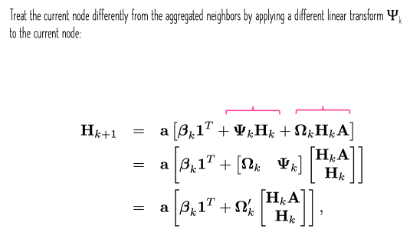